# Plotting CC_18 Benchmarks

In [1]:
%load_ext lab_black

In [1]:
import sys
from pathlib import Path
import numpy as np
import collections
import pickle
from pathlib import Path

import pandas as pd
import openml

from scipy.stats import wilcoxon
import dabest

from sklearn.metrics import cohen_kappa_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append("../")

# from oblique_forests.sporf import ObliqueForestClassifier
# from rerf.rerfClassifier import rerfClassifier

%load_ext autoreload
%autoreload 2

In [2]:
def continuous_pairplot(df, vars, hue, cmap, diag_kind="auto", scale="log"):
    import matplotlib as mpl
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    vmin = min(np.nanmin([df[hue]]), -1e-6)
    vmax = max(np.nanmax([df[hue]]), 1e-6)

    g = sns.pairplot(
        df,
        vars=vars,
        diag_kind=diag_kind,
        plot_kws=dict(
            # The effort I put into figuring this out.....
            c=df[hue],
            cmap=cmap,
            norm=mpl.colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax),
        ),
    )
    if scale:
        for r in range(len(g.axes)):
            for c in range(len(g.axes)):
                g.axes[r, c].set_xscale(scale)
                if r != c:
                    g.axes[c, r].set_yscale(scale)

    sm = mpl.cm.ScalarMappable(
        mpl.colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax), cmap=cmap
    )
    plt.colorbar(sm, ax=g.axes, label=hue, aspect=40)
    return g

# Define Data Directories

In [8]:
# directory to save the output
data_dir = Path("/home/adam2392/Downloads")
data_dir = Path("/Users/adam2392/Dropbox/sporf_benchmarks")

exp_name = "cysporf_vs_rerf_vs_rf"
exp_name = "cysporf_vs_rf_without_nominal"
# cross validation
n_splits = 10
# hyperparameters of forest
max_features = 'sqrt'

data_path = data_dir / exp_name / f"results_cv{n_splits}_features={max_features}"
print(data_path)

/Users/adam2392/Dropbox/sporf_benchmarks/cysporf_vs_rf_without_nominal/results_cv10_features=sqrt


In [9]:
# folder with saved results
result_files = [f for f in data_path.glob("*.pkl")]
print(len(result_files))

64


# Load Data

In [17]:
tasks = []
n_samples = []
n_classes = []
n_features = []
sporf_cohens = []
rf_cohens = []
rerf_sporf_cohens = []
task_ids = []

rf_times = []
rerf_times = []
cysporf_times = []

In [18]:
names = [
    "rf", 
#          "rerfsporf",
    "cysporf"]
for fpath in result_files:
    with open(fpath, "rb") as fin:
        result_dict = pickle.load(fin)

    for name in names:
        metadata = result_dict[f"{name}_metadata"]

        if name == "rf":
            rf_times.append(metadata["train_times"])
        elif name == "rerfsporf":
            rerf_times.append(metadata["train_times"])
        elif name == "cysporf":
            cysporf_times.append(metadata["train_times"])

In [21]:
print(metadata.keys())

dict_keys(['test_indices', 'train_times', 'test_times'])


In [22]:
for fpath in result_files:
    with open(fpath, "rb") as fin:
        result_dict = pickle.load(fin)

    # number of stratified cross-validations
    cv = result_dict["cv"]
    y = result_dict["y"]
    task_name = result_dict["task"]
    n_feature = result_dict["n_features"]
    #     n_feature = _get_task_id(desired_task_name=task_name)

    # extract metadata of benchmark experiment
    tasks.append(task_name)
    n_samples.append(result_dict["n_samples"])
    n_classes.append(result_dict["n_classes"])
    task_ids.append(result_dict["task_id"])
    n_features.append(n_feature)

    # compute cohen kappa for both classifiers
    for clf in names:
        fold_test_inds = result_dict[f"{clf}_metadata"]["test_indices"]
        clf_cohens = []
        fold_probas = result_dict[clf]

        # compute statistic on each fold
        for ifold in range(cv):
            y_proba = fold_probas[ifold][0]
            y_test = y[fold_test_inds[ifold]]
            kappa_score = cohen_kappa_score(y_test, y_proba.argmax(1))
            clf_cohens.append(kappa_score)

        if clf == "rf":
            rf_cohens.append(clf_cohens)
        elif clf == "rerfsporf":
            rerf_sporf_cohens.append(clf_cohens)
        else:
            sporf_cohens.append(clf_cohens)

## Format Data Into DataFrame

In [43]:
result_df = pd.DataFrame((tasks, n_samples, n_classes, task_ids, n_features)).T
result_df.columns = ["task", "n_samples", "n_classes", "task_id", "n_features"]

print(result_df.shape)
display(result_df.head())

(65, 5)


,task,n_samples,n_classes,task_id,n_features
0,Devnagari-Script,92000,46,167121,1024
1,Devnagari-Script,92000,46,167121,1024
2,segment,2310,7,146822,16
3,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,6
4,pc1,1109,2,3918,21


In [44]:
rf_df = pd.DataFrame(rf_cohens)
rf_df["clf"] = "rf"
rf_df = pd.concat((rf_df, result_df), axis=1)

In [45]:
sporf_df = pd.DataFrame(sporf_cohens)
sporf_df["clf"] = "cysporf"
sporf_df = pd.concat((sporf_df, result_df), axis=1)

In [26]:
rerf_df = pd.DataFrame(rerf_sporf_cohens)
rerf_df["clf"] = "rerfsporf"
rerf_df = pd.concat((rerf_df, result_df), axis=1)

In [27]:
# rerf - rf
diff_rerf_rf_arr = np.array(rerf_sporf_cohens) - np.array(rf_cohens)
diff_rerf_rf_df = pd.DataFrame(diff_rerf_rf_arr)
diff_rerf_rf_df = pd.concat((diff_rerf_rf_df, result_df), axis=1)

ValueError: operands could not be broadcast together with shapes (0,) (64,10) 

In [30]:
# sporf - rf
diff_sporf_rf_arr = np.array(sporf_cohens) - np.array(rf_cohens)
diff_sporf_rf_df = pd.DataFrame(diff_sporf_rf_arr)
diff_sporf_rf_df = pd.concat((diff_sporf_rf_df, result_df), axis=1)

## Melt DataFrames for Seaborn Plotting

In [34]:
# compute descending order by median
order = (
    diff_sporf_df_melt.groupby("task")
    .median()
    .sort_values(by="delta_cohen_kappa", ascending=False)
)

/Users/adam2392/miniforge3/envs/sklearn-dev/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


done


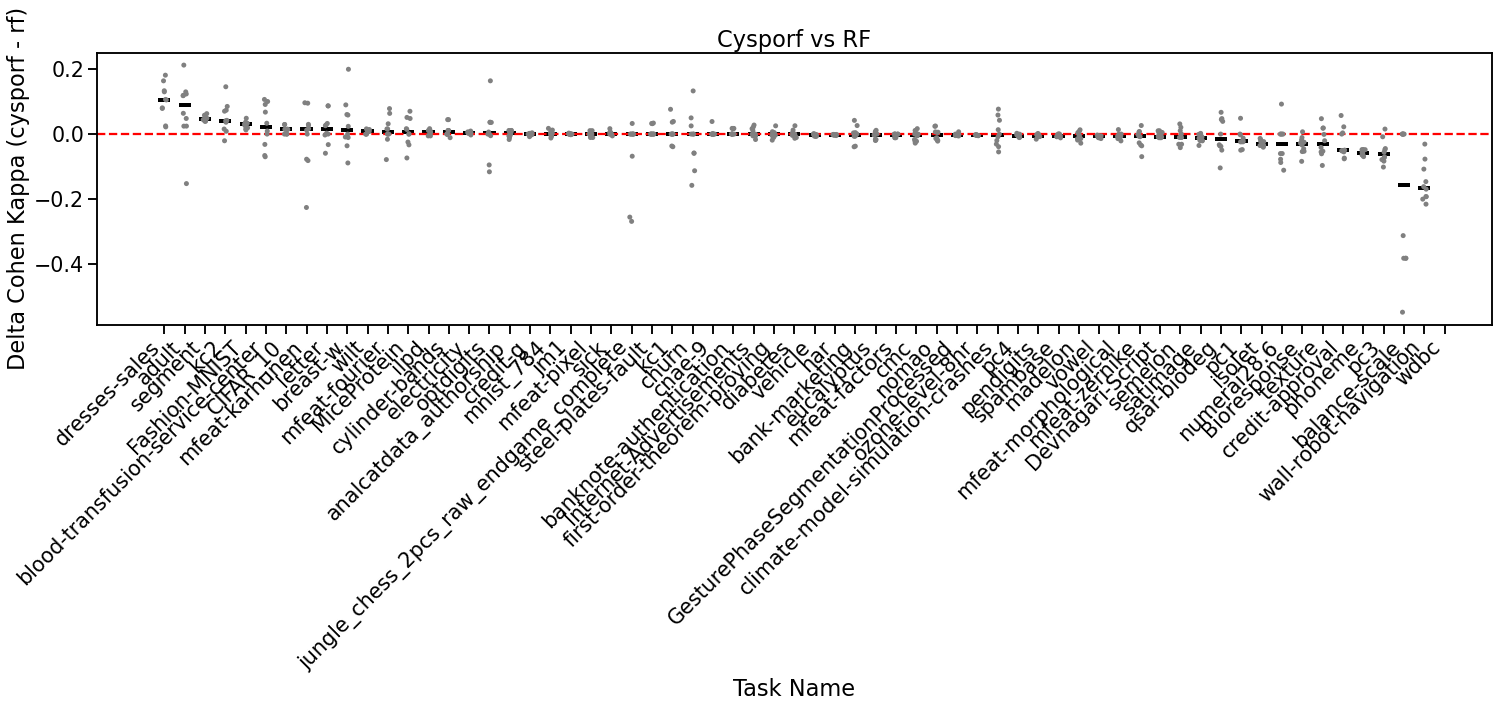

In [35]:
sns.set_context("talk", font_scale=1.25)
fig, ax = plt.subplots(figsize=(25, 5))
df = diff_sporf_df_melt
sns.stripplot(
    x="task",
    y="delta_cohen_kappa",
    data=df,
    color="gray",
    order=order.index,
    ax=ax,
)

# distance across the "X" or "Y" stipplot column to span, in this case 40%
median_width = 0.4
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    sample_name = text.get_text()  # "X" or "Y"

    # calculate the median value for all replicates of either X or Y
    median_val = df[df["task"] == sample_name]["delta_cohen_kappa"].median()

    # plot horizontal lines across the column, centered on the tick
    ax.plot(
        [tick - median_width / 2, tick + median_width / 2],
        [median_val, median_val],
        lw=4,
        color="k",
    )
ax.axhline([0], color="red", ls="--", label="No Change")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set(
    ylabel="Delta Cohen Kappa (cysporf - rf)", xlabel="Task Name", title="Cysporf vs RF"
)
# fig.tight_layout()
print("done")

In [29]:
# melt the dataframe
diff_sporf_df_melt = pd.melt(
    diff_sporf_rf_df,
    id_vars=["task", "n_samples", "n_classes", "task_id", "n_features"],
    value_name="delta_cohen_kappa",
    var_name="cv_fold",
)

display(diff_sporf_df_melt.head())

,task,n_samples,n_classes,task_id,n_features,cv_fold,delta_cohen_kappa
0,Devnagari-Script,92000,46,167121,1024,0,-0.008000
1,Devnagari-Script,92000,46,167121,1024,0,-0.010101
2,segment,2310,7,146822,16,0,0.050505
3,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,6,0,0.000000
4,pc1,1109,2,3918,21,0,0.000000


# Create Plots of Delta Cohen Kappa (SPORF implementations vs RF)

In [36]:
# df.groupby('StationID', as_index=False)['BiasTemp'].mean()
diff_sporf_df_melt.groupby("task", as_index=False)["delta_cohen_kappa"].mean()

,task,delta_cohen_kappa
0,Bioresponse,-0.034336
1,CIFAR_10,0.013263
2,Devnagari-Script,-0.003737
3,Fashion-MNIST,0.028655
4,GesturePhaseSegmentationProcessed,-0.002336
...,...,...
59,vehicle,-0.002756
60,vowel,-0.007757
61,wall-robot-navigation,-0.149231
62,wdbc,NaN


In [37]:
# compute descending order by median
order = (
    diff_sporf_df_melt.groupby("task")
    .median()
    .sort_values(by="delta_cohen_kappa", ascending=False)
)

done


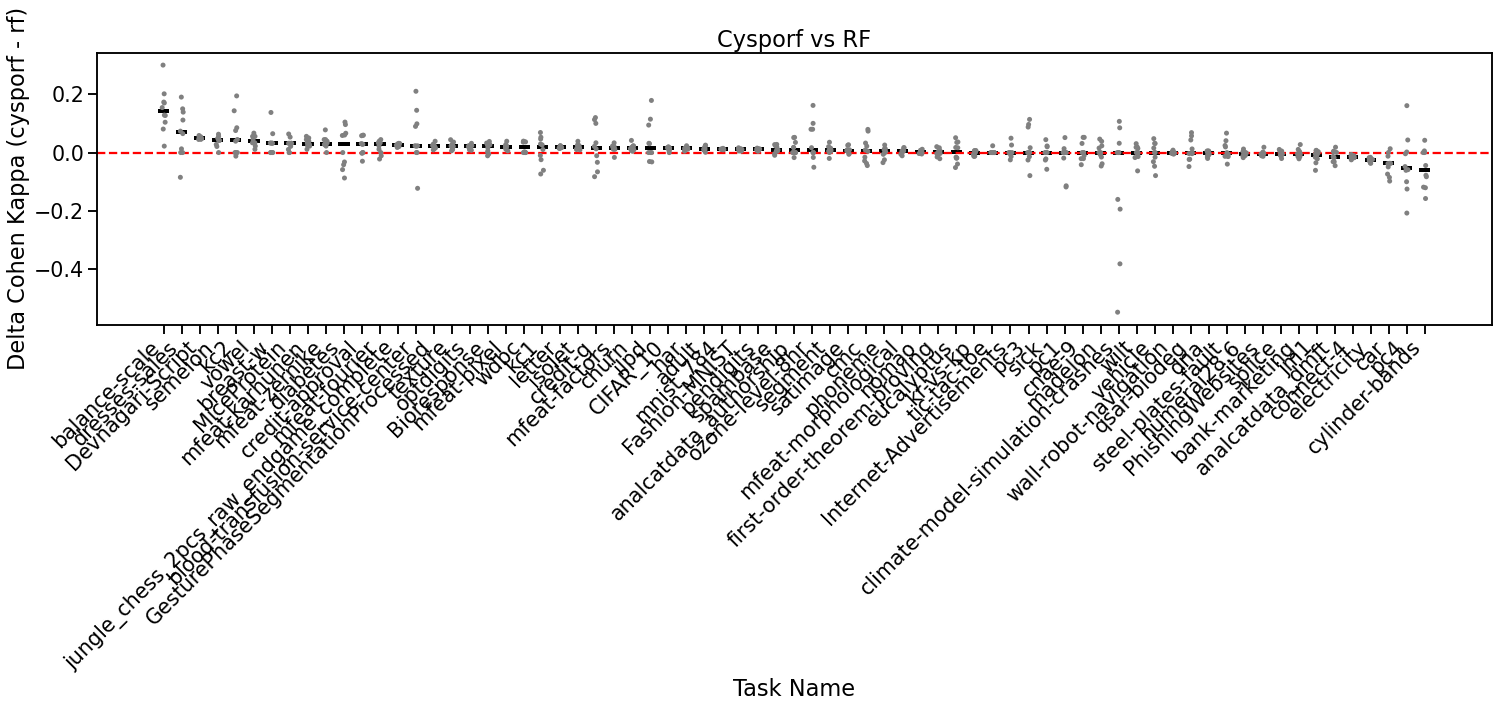

In [15]:
sns.set_context("talk", font_scale=1.25)
fig, ax = plt.subplots(figsize=(25, 5))
df = diff_sporf_df_melt
sns.stripplot(
    x="task",
    y="delta_cohen_kappa",
    data=df,
    color="gray",
    order=order.index,
    ax=ax,
)

# distance across the "X" or "Y" stipplot column to span, in this case 40%
median_width = 0.4
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    sample_name = text.get_text()  # "X" or "Y"

    # calculate the median value for all replicates of either X or Y
    median_val = df[df["task"] == sample_name]["delta_cohen_kappa"].median()

    # plot horizontal lines across the column, centered on the tick
    ax.plot(
        [tick - median_width / 2, tick + median_width / 2],
        [median_val, median_val],
        lw=4,
        color="k",
    )
ax.axhline([0], color="red", ls="--", label="No Change")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set(
    ylabel="Delta Cohen Kappa (cysporf - rf)", xlabel="Task Name", title="Cysporf vs RF"
)
# fig.tight_layout()
print("done")

In [16]:
# compute descending order by median
order = (
    diff_rerf_df_melt.groupby("task")
    .median()
    .sort_values(by="delta_cohen_kappa", ascending=False)
)

done


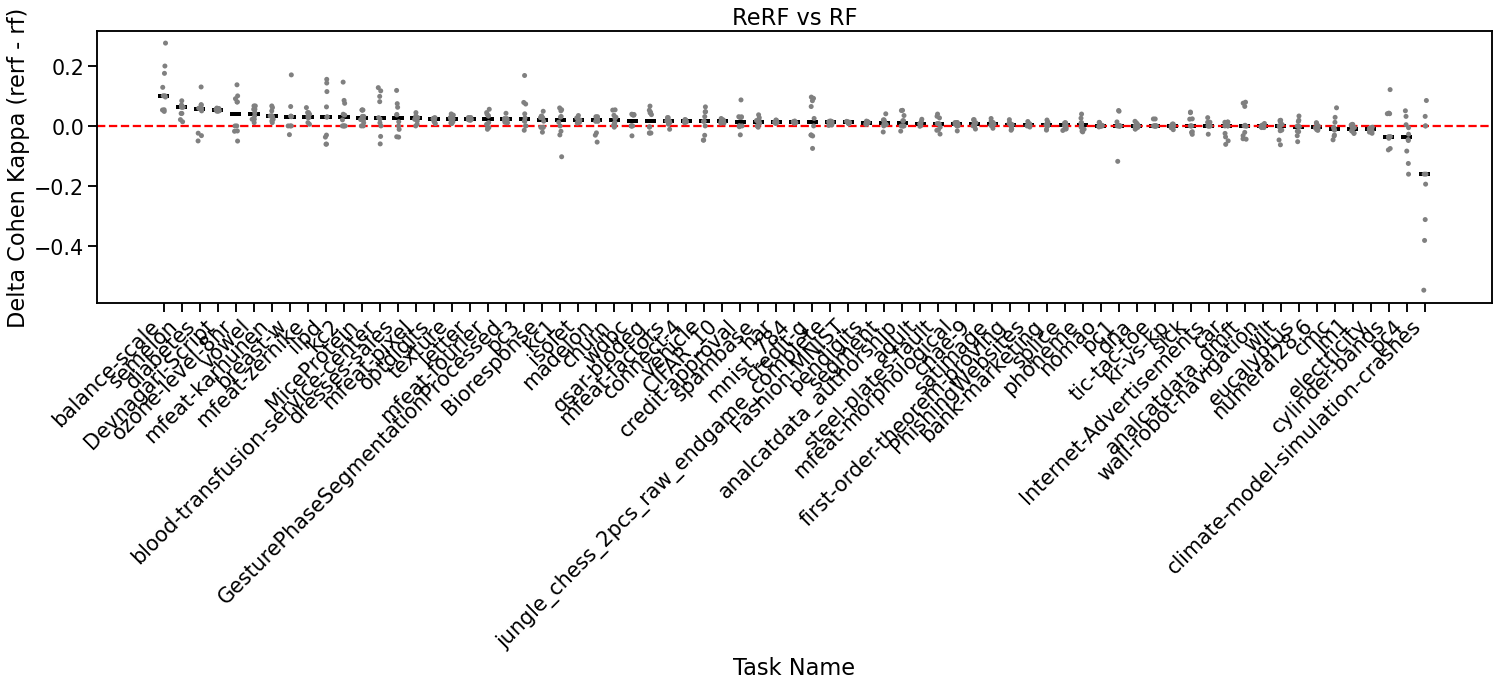

In [17]:
sns.set_context("talk", font_scale=1.25)
fig, ax = plt.subplots(figsize=(25, 5))
df = diff_rerf_df_melt
sns.stripplot(
    x="task",
    y="delta_cohen_kappa",
    data=df,
    color="gray",
    order=order.index,
    ax=ax,
)

# distance across the "X" or "Y" stipplot column to span, in this case 40%
median_width = 0.4
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    sample_name = text.get_text()  # "X" or "Y"

    # calculate the median value for all replicates of either X or Y
    median_val = df[df["task"] == sample_name]["delta_cohen_kappa"].median()

    # plot horizontal lines across the column, centered on the tick
    ax.plot(
        [tick - median_width / 2, tick + median_width / 2],
        [median_val, median_val],
        lw=4,
        color="k",
    )
ax.axhline([0], color="red", ls="--", label="No Change")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set(ylabel="Delta Cohen Kappa (rerf - rf)", xlabel="Task Name", title="ReRF vs RF")
# fig.tight_layout()
print("done")

In [38]:
cols = ["n_samples", "n_classes", "n_features"]
diff_sporf_df_melt[cols] = diff_sporf_df_melt[cols].apply(
    pd.to_numeric, errors="coerce"
)

sporf_df = diff_sporf_df_melt.groupby("task").median()


In [39]:

diff_rerf_df_melt[cols] = diff_rerf_df_melt[cols].apply(pd.to_numeric, errors="coerce")
rerf_df = diff_rerf_df_melt.groupby("task").median()



NameError: name 'diff_rerf_df_melt' is not defined

In [ ]:

display(sporf_df.head())
display(rerf_df.head())
# df.groupby('gender')['convertedcomp'].median()

In [40]:
continuous_pairplot(
    rerf_df,
    vars=["n_classes", "n_samples", "n_features"],
    hue="delta_cohen_kappa",
    cmap="coolwarm",
)

KeyError: 'delta_cohen_kappa'

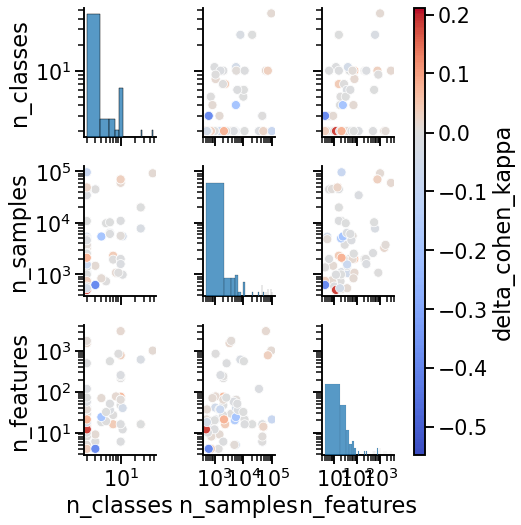

In [41]:
continuous_pairplot(
    diff_sporf_df_melt,
    vars=["n_classes", "n_samples", "n_features"],
    hue="delta_cohen_kappa",
    cmap="coolwarm",
)

# Runtime Performance

In [21]:
rf_times_df = pd.DataFrame(rf_times)
rf_df["clf"] = "rf"
rf_df = pd.concat((rf_times_df, result_df), axis=1)

rerf_times_df = pd.DataFrame(rerf_times)
rerf_df["clf"] = "rerfsporf"
rerf_df = pd.concat((rerf_times_df, result_df), axis=1)

sporf_times_df = pd.DataFrame(cysporf_times)
sporf_df["clf"] = "cysporf"
sporf_df = pd.concat((sporf_times_df, result_df), axis=1)

In [22]:
# melt the dataframe
sporf_df_melt = pd.melt(
    sporf_df,
    id_vars=["task", "n_samples", "n_classes", "task_id", "n_features"],
    value_name="times",
    var_name="cv_fold",
)
sporf_df_melt["clf"] = "cysporf"

# melt the dataframe
rf_df_melt = pd.melt(
    rf_df,
    id_vars=["task", "n_samples", "n_classes", "task_id", "n_features"],
    value_name="times",
    var_name="cv_fold",
)
rf_df_melt["clf"] = "rf"

# melt the dataframe
rerf_df_melt = pd.melt(
    rerf_df,
    id_vars=["task", "n_samples", "n_classes", "task_id", "n_features"],
    value_name="times",
    var_name="cv_fold",
)
rerf_df_melt["clf"] = "rerf"

times_df = pd.concat(
    (
        rf_df_melt,
        #                       rerf_df_melt,
        sporf_df_melt,
    ),
    axis=0,
)

display(times_df.head())
print(times_df.shape)
display(sporf_df_melt.head())

,task,n_samples,n_classes,task_id,n_features,cv_fold,times,clf
0,Devnagari-Script,92000,46,167121,1024,0,1280.741402,rf
1,segment,2310,7,146822,16,0,0.987333,rf
2,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,6,0,2.116413,rf
3,tic-tac-toe,958,2,49,9,0,0.953501,rf
4,pc1,1109,2,3918,21,0,0.896651,rf


(1420, 8)


,task,n_samples,n_classes,task_id,n_features,cv_fold,times,clf
0,Devnagari-Script,92000,46,167121,1024,0,2121.569089,cysporf
1,segment,2310,7,146822,16,0,1.020177,cysporf
2,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,6,0,2.746897,cysporf
3,tic-tac-toe,958,2,49,9,0,1.016986,cysporf
4,pc1,1109,2,3918,21,0,0.940076,cysporf


done


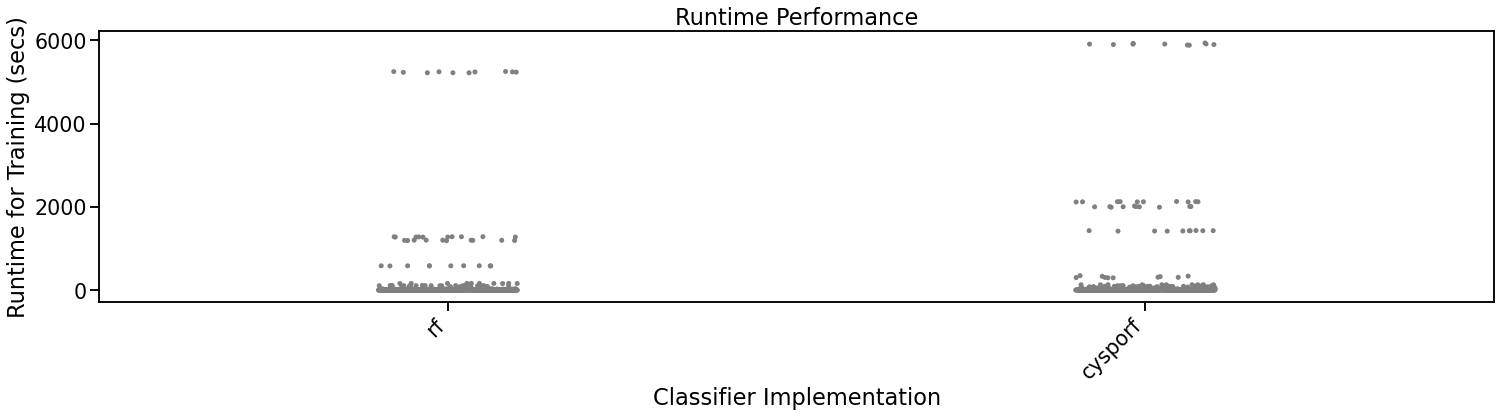

In [23]:
sns.set_context("talk", font_scale=1.25)
fig, ax = plt.subplots(figsize=(25, 5))
df = times_df
sns.stripplot(
    x="clf",
    y="times",
    data=times_df,
    color="gray",
    #     order=order.index,
    ax=ax,
)

# distance across the "X" or "Y" stipplot column to span, in this case 40%
# median_width = 0.4
# for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
#     sample_name = text.get_text()  # "X" or "Y"

#     # calculate the median value for all replicates of either X or Y
#     median_val = df[df["task"] == sample_name]["delta_cohen_kappa"].median()

#     # plot horizontal lines across the column, centered on the tick
#     ax.plot(
#         [tick - median_width / 2, tick + median_width / 2],
#         [median_val, median_val],
#         lw=4,
#         color="k",
#     )
# ax.axhline([0], color="red", ls="--", label="No Change")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set(
    ylabel="Runtime for Training (secs)",
    xlabel="Classifier Implementation",
    title="Runtime Performance",
)
# ax.set_yscale("log")
# fig.tight_layout()
print("done")

done


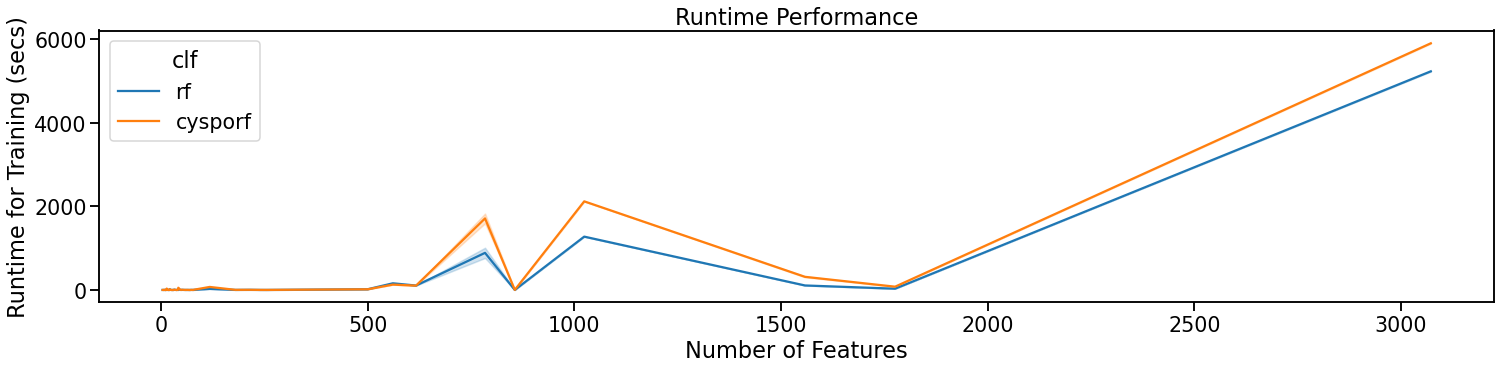

In [24]:
sns.set_context("talk", font_scale=1.25)
fig, ax = plt.subplots(figsize=(25, 5))
df = times_df
sns.lineplot(
    x="n_features",
    y="times",
    data=times_df,
    hue="clf",
    #     color="gray",
    #     order=order.index,
    ax=ax,
)

ax.set(
    ylabel="Runtime for Training (secs)",
    xlabel="Number of Features",
    title="Runtime Performance",
)
# ax.set_yscale("log")
# fig.tight_layout()
print("done")

done


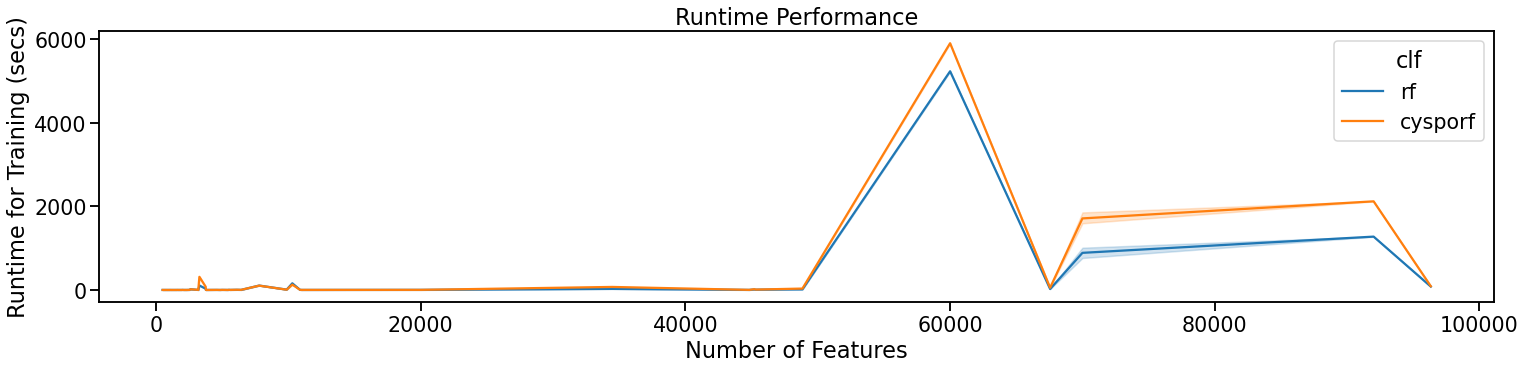

In [25]:
sns.set_context("talk", font_scale=1.25)
fig, ax = plt.subplots(figsize=(25, 5))
df = times_df
sns.lineplot(
    x="n_samples",
    y="times",
    data=times_df,
    hue="clf",
    #     color="gray",
    #     order=order.index,
    ax=ax,
)

ax.set(
    ylabel="Runtime for Training (secs)",
    xlabel="Number of Features",
    title="Runtime Performance",
)
# ax.set_yscale("log")
# fig.tight_layout()
print("done")

# Statistical Testing

Here, we compare performances in terms of cohens' kappa and runtime.

In [46]:
# melt the dataframe
sporf_df_melt = pd.melt(
    sporf_df,
    id_vars=["task", "n_samples", "n_classes", "task_id", "n_features", "clf"],
    value_name="cohen_kappa",
    var_name="cv_fold",
)

display(sporf_df_melt.head())

,task,n_samples,n_classes,task_id,n_features,clf,cv_fold,cohen_kappa
0,Devnagari-Script,92000,46,167121,1024,cysporf,0,0.909444
1,Devnagari-Script,92000,46,167121,1024,cysporf,0,0.934343
2,segment,2310,7,146822,16,cysporf,0,0.678524
3,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,6,cysporf,0,0.523605
4,pc1,1109,2,3918,21,cysporf,0,0.717043


In [47]:
# melt the dataframe
rf_df_melt = pd.melt(
    rf_df,
    id_vars=["task", "n_samples", "n_classes", "task_id", "n_features", "clf"],
    value_name="cohen_kappa",
    var_name="cv_fold",
)

display(rf_df_melt.head())

,task,n_samples,n_classes,task_id,n_features,clf,cv_fold,cohen_kappa
0,Devnagari-Script,92000,46,167121,1024,rf,0,0.917444
1,Devnagari-Script,92000,46,167121,1024,rf,0,0.944444
2,segment,2310,7,146822,16,rf,0,0.628019
3,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,6,rf,0,0.523605
4,pc1,1109,2,3918,21,rf,0,0.717043


In [48]:
rf_vals = rf_df_melt["cohen_kappa"]
sporf_vals = sporf_df_melt["cohen_kappa"]

# perform paired wilcoxon test
stat, pval = wilcoxon(sporf_vals, rf_vals, alternative="greater")
print(pval)

0.9942803646351084


In [49]:
df_1 = sporf_df_melt.reset_index()
df_2 = rf_df_melt.reset_index()

joint_df = pd.concat((df_1, df_2), axis=0)

print(joint_df.shape, sporf_df_melt.shape)

display(joint_df.head(2))

(1300, 9) (650, 8)


,index,task,n_samples,n_classes,task_id,n_features,clf,cv_fold,cohen_kappa
0,0,Devnagari-Script,92000,46,167121,1024,cysporf,0,0.909444
1,1,Devnagari-Script,92000,46,167121,1024,cysporf,0,0.934343


In [81]:
ck_dabest = dabest.load(
    joint_df,
    idx=(
        "cysporf",
        "rf",
    ),
    x="clf",
    y="cohen_kappa",
    id_col="index",
    paired=True,
)

In [84]:
ck_dabest.mean_diff

DABEST v0.3.1
             
Good evening!
The current time is Mon Aug 23 12:40:48 2021.

The paired mean difference between cysporf and rf is -0.0109 [95%CI -0.0145, -0.00677].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`

/Users/adam2392/miniforge3/envs/sklearn-dev/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


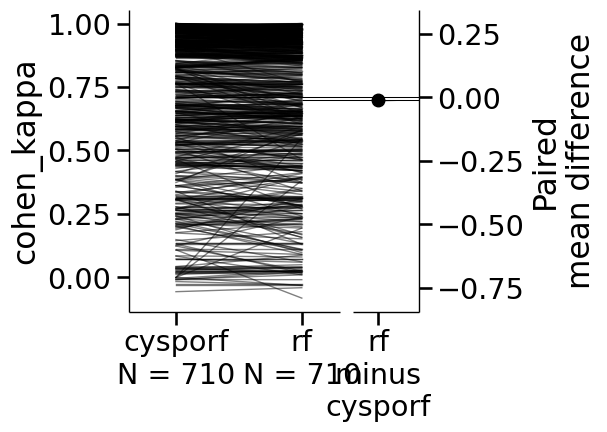

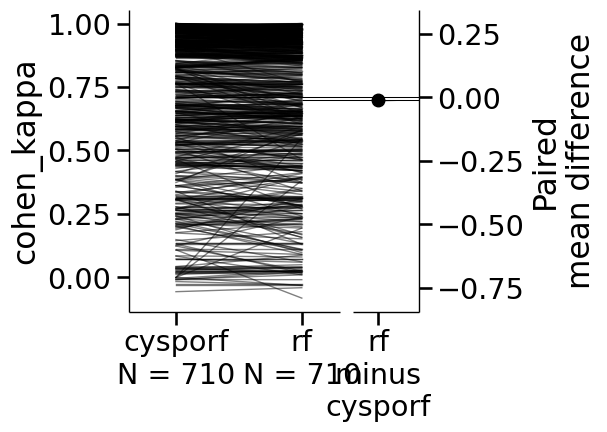

In [85]:
ck_dabest.mean_diff.plot()

In [ ]:
mean_diff